*Mehrdad Mokhtari*

*NLP Data Scientist - Chata Technology Inc.*

**This Colab was adopted from [this page](https://colab.research.google.com/drive/16gx06PVffJwS4pRhysCmc5qbPm26vsY8).**

----------------

# Introduction


In this notebook, I'll show you how to finetune the pretrained XLNet model with the huggingface PyTorch library to quickly produce a classifier for text classification.


## What is XLNet?

XLNet is a method of pretraining language representations developed by CMU and Google researchers in mid-2019. XLNet was created to address what the authors saw as the shortcomings of the autoencoding method of pretraining used by BERT and other popular language models. We won't get into the details of XLNet in this post, but the authors favored a custom autoregressive method. This pretraining method resulted in models that outperformed BERT on a range of NLP tasks and resulted in a new state of the art model. 


## Install and Import

Google Colab offers free GPUs and TPUs! Since we'll be training a large neural network it's best to take advantage of this (in this case we'll attach a GPU), otherwise training will take a very long time.

A GPU can be added by going to the menu and selecting:

Edit -> Notebook Settings -> Add accelerator (GPU)

Then run the following cell to confirm that the GPU is detected.

In [2]:
import tensorflow as tf
# !export CUDA_LAUNCH_BLOCKING=1

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


Next, let's install the pytorch interface for XLNet by Hugging Face. (This library contains interfaces for other pretrained language models like OpenAI's GPT, BERT, and GPT-2.) We've selected the pytorch interface because it strikes a nice balance between the high-level APIs (which are easy to use but don't provide insight into how things work) and tensorflow code (which contains lots of details but often sidetracks us into lessons about tensorflow)

At the moment, the Hugging Face library seems to be the most widely accepted and powerful pytorch interface for working with transfer learning models. In addition to supporting a variety of different pre-trained language models (and future models to come - just a few short months after the publication of BERT and XLNet, both have been outperformed by new models!), the library also includes pre-built modifications of different models suited to your specific task. For example, in this tutorial we will use XLNetForSequenceClassification, but the library also includes model modifications designed for token classification, question answering, next sentence prediciton, etc. Using these pre-built classes simplifies the process of modifying transfer learning models for your purposes.


In [3]:
!pip install pytorch-transformers

     |████████████████████████████████| 184kB 8.8MB/s 
     |████████████████████████████████| 1.1MB 9.5MB/s 
     |████████████████████████████████| 890kB 29.8MB/s 
     |████████████████████████████████| 133kB 49.3MB/s 
     |████████████████████████████████| 71kB 10.6MB/s 
     |████████████████████████████████| 7.1MB 48.6MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=080406b448563310a92428ce5277172bf3ec4b4f893d8ce7a5a1fda1352b54ab
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses
ERROR: botocore 1.19.35 has requirement urllib3<1.27,>=1.25.4; python_version != "3.4", but you'll have urllib3 1.24.3 which is incompatible.


In [4]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

!pip install transformers
import transformers
# from pytorch_transformers import XLNetTokenizer, XLNetForSequenceClassification
# from pytorch_transformers import AdamW
from transformers import XLNetTokenizer, XLNetModel, XLNetForSequenceClassification
from transformers import AdamW

from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

     |████████████████████████████████| 1.4MB 8.4MB/s 
     |████████████████████████████████| 2.9MB 28.9MB/s 


In order for torch to use the GPU, we need to identify and specify the GPU as the device. Later, in our training loop, we will load data onto the device. 

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla T4'

## Load Dataset


The dataset represents hotel reviews and their ratings. There are 5 ratings that are the labels to be predicted based on the text in the reviews. You have been given the ratings for the train and dev sets. The ratings on the test set have been withheld. 

Data Download Path: https://chataai.sharepoint.com/:f:/g/EtI-zi28qBJKjafd6BVpkTgBNM906KqOA3zfZU4fXXMGeA?e=fMEKGx

**Column 1**:	id

**Column 2**:	 review

**Column 3**:	 rating

In [6]:
# Upload the train file from your local drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# Load data

data_train = pd.read_csv('/content/drive/My Drive/Chata-dataset/sentiment_dataset_train.csv', engine='python', encoding='utf-8', error_bad_lines=False)
data_dev = pd.read_csv('/content/drive/My Drive/Chata-dataset/sentiment_dataset_dev.csv', engine='python', encoding='utf-8', error_bad_lines=False)
data_test = pd.read_csv('/content/drive/My Drive/Chata-dataset/sentiment_dataset_test.csv', engine='python', encoding='utf-8', error_bad_lines=False)

# data_train.shape
data_dev.head()

,id,review,rating
0,0,"The hotel position is very good, center of the...",2
1,1,Not a very big room but very comfortable and c...,4
2,2,The hotel is located near Kurfürstendamm in a ...,4
3,3,My booking was for 2 rooms and I have made the...,2
4,4,"Excellent hotel, fantastic swimming pool, very...",5


In [8]:
data_train.shape

(35005, 3)

In [9]:
# If you remember, there was one example in the training set that some unwanted texts got into its rating. 
# So, I just remove that row! (learnt from EDA of basic model)

for i in range(len(data_train)):
    if not data_train['rating'][i].isnumeric():
        data_train.drop(i, inplace = True)
        print('Yes', i)

# Change 'rating' type from Object to int
data_train['rating'] = data_train['rating'].astype(str).astype(int)

Yes 30944


In [10]:
# For multiclass classification, the labels should be integers starting from 0. 
# 'rating' column should look like [0,1,2,3,4] in our case!

# Ref: https://medium.com/swlh/simple-transformers-multi-class-text-classification-with-bert-roberta-xlnet-xlm-and-8b585000ce3a

data_train['rating'] = data_train['rating'] - 1
data_dev['rating'] = data_dev['rating'] - 1


In [11]:
# Clean data - remove emoji’s:
# REF: https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b
# import re

# def remove_emoji(text):
#     emoji_pattern = re.compile("["
#                            u"\U0001F600-\U0001F64F"  # emoticons
#                            u"\U0001F300-\U0001F5FF"  # symbols & pictographs
#                            u"\U0001F680-\U0001F6FF"  # transport & map symbols
#                            u"\U0001F1E0-\U0001F1FF"  # flags 
#                            u"\U00002702-\U000027B0"
#                            u"\U000024C2-\U0001F251"
#                            "]+", flags=re.UNICODE)
#     return emoji_pattern.sub(r'', text)

# data_train['review_new'] = data_train['review'].apply(lambda x: remove_emoji(x))
# data_dev['review_new'] = data_dev['review'].apply(lambda x: remove_emoji(x))
# data_test['review_new'] = data_test['review'].apply(lambda x: remove_emoji(x))

# Data cleaning will not change the final result at all!

In [12]:
# Create sentence and label lists

sentences_train = data_train['review'].values

We need to add special tokens ("[SEP]" and "[CLS]") at the beginning and end of each sentence for XLNet to work properly. 

For BERT, the special token pattern looks like this:

    [CLS] + Sentence_A + [SEP] + Sentence_B + [SEP]

Whereas with XLNet the token pattern looks like this:

    Sentence_A + [SEP] + Sentence_B + [SEP] + [CLS]
    
For single sentence inputs here, we just need to add [SEP] and [CLS] to the end:

In [13]:
sentences_train = [sentence + " [SEP] [CLS]" for sentence in sentences_train]

labels_train = data_train['rating'].values

## Inputs

Next, import the XLNet tokenizer, used to convert our text into tokens that correspond to XLNet's vocabulary.

In [14]:
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased', do_lower_case=True)

tokenized_texts_train = [tokenizer.tokenize(sent) for sent in sentences_train]
# tokenized_texts_dev = [tokenizer.tokenize(sent) for sent in sentences_dev]
print ("Tokenize the first sentence in train set:")
print (tokenized_texts_train[0])


Tokenize the first sentence in train set:
['▁arrived', '▁about', '▁10', 'pm', '▁and', '▁check', '▁in', '▁was', '▁pain', 'less', '.', '▁the', '▁only', '▁downside', '▁to', '▁this', '▁hotel', '▁is', '▁if', '▁you', '▁are', '▁looking', '▁for', '▁a', '▁city', '▁centre', '▁location', '.', '▁if', '▁you', '▁don', "'", 't', '▁mind', '▁some', '▁walking', '▁and', '▁want', '▁to', '▁be', '▁out', '▁of', '▁the', '▁noise', '▁of', '▁the', '▁city', '▁then', '▁this', '▁place', '▁is', '▁ideal', '.', '▁hotel', '▁has', '▁a', '▁bar', '▁and', '▁restaurant', ',', '▁decent', '▁size', '▁gym', '▁and', '▁roof', '▁terrace', '▁with', '▁sun', '▁lounge', 'rs', '.', '▁the', '▁rooms', '▁are', '▁a', '▁good', '▁size', ',', '▁especially', '▁when', '▁traveling', '▁with', '▁a', '▁large', '▁teenager', '.', '▁good', '▁', 'sized', '▁lounge', '▁with', '▁double', '▁sofa', '▁bed', ',', '▁kitchen', '▁area', '▁and', '▁dining', '▁table', '.', '▁main', '▁bedroom', '▁is', '▁a', '▁good', '▁size', '▁with', '▁double', '▁wardrobe', 's', '▁

XLNet requires specifically formatted inputs. For each tokenized input sentence, we need to create:

- **input ids**: a sequence of integers identifying each input token to its index number in the XLNet tokenizer vocabulary
- **segment mask**: (optional) a sequence of 1s and 0s used to identify whether the input is one sentence or two sentences long. For one sentence inputs, this is simply a sequence of 0s. For two sentence inputs, there is a 0 for each token of the first sentence, followed by a 1 for each token of the second sentence
- **attention mask**: (optional) a sequence of 1s and 0s, with 1s for all input tokens and 0s for all padding tokens (we'll detail this in the next paragraph)
- **labels**: a single value of 1 or 0. In our task 1 means "grammatical" and 0 means "ungrammatical"

Although we can have variable length input sentences, XLNet does requires our input arrays to be the same size. We address this by first choosing a maximum sentence length, and then padding and truncating our inputs until every input sequence is of the same length. 

To "pad" our inputs in this context means that if a sentence is shorter than the maximum sentence length, we simply add 0s to the end of the sequence until it is the maximum sentence length. 

If a sentence is longer than the maximum sentence length, then we simply truncate the end of the sequence, discarding anything that does not fit into our maximum sentence length.

We pad and truncate our sequences so that they all become of length MAX_LEN ("post" indicates that we want to pad and truncate at the end of the sequence, as opposed to the beginning) `pad_sequences` is a utility function that we're borrowing from Keras. It simply handles the truncating and padding of Python lists.

In [15]:
# Set the maximum sequence length. The longest sequence in our training set is ?35?, but we'll leave room on the end anyway. 
MAX_LEN = 128

In [16]:
# Use the XLNet tokenizer to convert the tokens to their index numbers in the XLNet vocabulary
input_ids_train = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts_train]
# input_ids_dev = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts_dev]

In [17]:
# Pad our input tokens
input_ids_train = pad_sequences(input_ids_train, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
# input_ids_dev = pad_sequences(input_ids_dev, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

Create the attention masks 

In [18]:
# Create attention masks
attention_masks_train = []
# attention_masks_dev = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids_train:
    seq_mask = [float(i>0) for i in seq]
    attention_masks_train.append(seq_mask)

# for seq_dev in input_ids_dev:
#     seq_mask_dev = [float(i>0) for i in seq_dev]
#     attention_masks_dev.append(seq_mask_dev)

In [19]:
# Use train_test_split to split our data into train and validation sets for training
# To clarify: this validation set is different than our dev set! I use train set to randomly pick some validation set

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids_train, labels_train, 
                                                                                    random_state=2020, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks_train, input_ids_train,
                                                       random_state=2020, test_size=0.1)

In [20]:
# Convert all of our data into torch tensors, the required datatype for our model

train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [21]:
# Select a batch size for training. For fine-tuning with XLNet, the authors recommend a batch size of 32, 48, or 128. We will use 32 here to avoid memory issues.
batch_size = 32

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


## Train Model

Now that our input data is properly formatted, it's time to fine tune the XLNet model. 

For this task, we first want to modify the pre-trained model to give outputs for classification, and then we want to continue training the model on our dataset until that the entire model, end-to-end, is well-suited for our task. Thankfully, the huggingface pytorch implementation includes a set of interfaces designed for a variety of NLP tasks. Though these interfaces are all built on top of a trained model, each has different top layers and output types designed to accomodate their specific NLP task.  

We'll load [XLNetForSequenceClassification](https://github.com/huggingface/pytorch-transformers/blob/master/pytorch_transformers/modeling_xlnet.py#L1076). This is the normal XLNet model with an added single linear layer on top for classification that we will use as a sentence classifier. As we feed input data, the entire pre-trained XLNet model and the additional untrained classification layer is trained on our specific task. 

### The Fine-Tuning Process

Because the pre-trained model layers already encode a lot of information about the language, training the classifier is relatively inexpensive. Rather than training every layer in a large model from scratch, it's as if we have already trained the bottom layers 95% of where they need to be, and only really need to train the top layer, with a bit of tweaking going on in the lower levels to accomodate our task.

Sometimes practicioners will opt to "freeze" certain layers when fine-tuning, or to apply different learning rates, apply diminishing learning rates, etc. all in an effort to preserve the good quality weights in the network and speed up training (often considerably). In fact, recent research on transfer learning models like BERT specifically has demonstrated that freezing the majority of the weights results in only minimal accuracy declines, but there are exceptions and broader rules of transfer learning that should also be considered. For example, if your task and fine-tuning dataset is very different from the dataset used to train the transfer learning model, freezing the weights may not be a good idea.



OK, let's load XLNet! There are a few different pre-trained XLNet models available. "xlnet-base-cased" means the version that has both upper and lowercase letters ("cased") and is the smaller version of the two ("base" vs "large").

In [22]:
# Load XLNEtForSequenceClassification, the pretrained XLNet model with a single linear classification layer on top. 

model = XLNetForSequenceClassification.from_pretrained("xlnet-base-cased", num_labels=5)
model.cuda()

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.weight', 'sequence_summary.summary.bias', 'logits_proj.weight', 'logits_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

XLNetForSequenceClassification(
  (transformer): XLNetModel(
    (word_embedding): Embedding(32000, 768)
    (layer): ModuleList(
      (0): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (layer_1): Linear(in_features=768, out_features=3072, bias=True)
          (layer_2): Linear(in_features=3072, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (1): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e

Now that we have our model loaded we need to grab the training hyperparameters from within the stored model.

For the purposes of fine-tuning, the authors recommend the following hyperparameters in the following ranges (broken down by which NLP dataset they are applied to):


![alt text](https://i.imgur.com/AhirErN.png)

In [23]:

param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

In [24]:
# This variable contains all of the hyperparemeter information our training loop needs
optimizer = AdamW(optimizer_grouped_parameters, 
                  lr=3e-5) 

Below is our training loop. There's a lot going on, but fundamentally for each pass in our loop we have a training phase and a validation phase. At each pass we need to:

Training loop:
- Tell the model to compute gradients by setting the model in train mode
- Unpack our data inputs and labels
- Load data onto the GPU for acceleration
- Clear out the gradients calculated in the previous pass. In pytorch the gradients accumulate by default (useful for things like RNNs) unless you explicitly clear them out
- Forward pass (feed input data through the network)
- Backward pass (backpropagation)
- Tell the network to update parameters with optimizer.step()
- Track variables for monitoring progress

Evalution loop:
- Tell the model not to compute gradients by setting the model in evaluation mode
- Unpack our data inputs and labels
- Load data onto the GPU for acceleration
- Forward pass (feed input data through the network)
- Compute loss on our validation data and track variables for monitoring progress


In [25]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [26]:
# Store our loss and accuracy for plotting
train_loss_set = []

# Number of training epochs (authors recommend between 2 and 4)
epochs = 4

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):
  
  # Training
  
  # Set our model to training mode (as opposed to evaluation mode)
  model.train()
  
  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    print(batch)
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    loss = outputs[0]
    logits = outputs[1]
    train_loss_set.append(loss.item())    
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))
    
    
  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Tracking variables 
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      output = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
      logits = output[0]
    
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))
  
  # It might take up to an hour based on your RAM size while using GPU!
  # In this implementation, Tesla T4 GPU on Google Colab with 12G RAM is used!

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
        [1., 1., 1.,  ..., 0., 0., 0.]]), tensor([3, 4, 3, 4, 4, 4, 4, 2, 1, 4, 4, 4, 4, 2, 2, 4, 2, 0, 4, 1, 1, 0, 0, 2,
        3, 3, 2, 2, 2, 3, 0, 3])]
[tensor([[ 1685,    18, 22754,  ...,     0,     0,     0],
        [   80,  3859,    25,  ...,  3164,  2265,    77],
        [   80,    55,  2716,  ...,    57,  1129,    80],
        ...,
        [24917,    27,   172,  ...,     0,     0,     0],
        [  102,    17,   150,  ...,   220,    26,    46],
        [  970,    21,    17,  ...,   102,    19,  2824]]), tensor([[1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.]]), tensor([1, 4, 0, 0, 4, 1, 1, 2, 2, 0, 4, 3, 4, 2, 3, 4, 2, 1, 0, 0, 1, 1, 0, 3,
        0, 3, 1, 4, 2, 3, 0, 3])]
[tensor([[   80,  3859,   105,  ...,    46,  6723,  1022],
 

Epoch:  25%|██▌       | 1/4 [16:14<48:44, 974.67s/it]

Streaming output truncated to the last 5000 lines.
        [1., 1., 1.,  ..., 0., 0., 0.]]), tensor([1, 4, 3, 3, 4, 1, 3, 2, 3, 4, 4, 3, 3, 2, 3, 2, 0, 2, 1, 4, 4, 0, 3, 2,
        1, 2, 2, 0, 0, 2, 2, 1])]
[tensor([[   17,   150,   132,  ...,   150,  3132,    17],
        [  220,    26,    46,  ...,   641,   308,   136],
        [   17,   150,  4163,  ...,     0,     0,     0],
        ...,
        [ 1854,    27,  3251,  ...,    74,  1685,    36],
        [   18, 24917,    30,  ...,     0,     0,     0],
        [   17,   150,  1318,  ...,     0,     0,     0]]), tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.]]), tensor([2, 4, 4, 4, 0, 2, 0, 1, 1, 4, 2, 2, 3, 3, 3, 1, 4, 3, 1, 4, 4, 2, 2, 0,
        0, 1, 1, 2, 3, 1, 3, 4])]
[tensor([[   17,   150,    47,  ...,    24, 31298,    25],
 

Epoch:  50%|█████     | 2/4 [32:36<32:33, 976.89s/it]

Streaming output truncated to the last 5000 lines.
        [1., 1., 1.,  ..., 1., 1., 1.]]), tensor([1, 0, 4, 4, 2, 0, 1, 4, 3, 2, 3, 4, 2, 4, 1, 4, 4, 3, 0, 2, 0, 1, 2, 0,
        0, 4, 3, 0, 1, 3, 4, 4])]
[tensor([[   52,   250,    27,  ...,    65,   424,    20],
        [   18,   656,    38,  ...,   155,    17,    10],
        [   80,  1573,    52,  ...,     9,   480, 12915],
        ...,
        [   17,   150,    26,  ...,    31,    94,   205],
        [28066,   112,    50,  ...,  4145, 11974,    23],
        [   40,    18,  1901,  ...,     0,     0,     0]]), tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 0., 0., 0.]]), tensor([0, 2, 1, 3, 2, 2, 1, 1, 2, 0, 3, 1, 1, 3, 4, 4, 1, 3, 1, 4, 3, 0, 2, 4,
        0, 0, 2, 4, 3, 0, 0, 4])]
[tensor([[   17, 11935,    19,  ...,    91,    24,   156],
 

Epoch:  75%|███████▌  | 3/4 [49:03<16:19, 979.81s/it]

Streaming output truncated to the last 5000 lines.
        [1., 1., 1.,  ..., 1., 1., 1.]]), tensor([1, 0, 4, 0, 3, 0, 2, 1, 3, 1, 4, 0, 3, 4, 0, 4, 4, 0, 0, 4, 2, 4, 4, 0,
        0, 3, 2, 2, 0, 3, 0, 1])]
[tensor([[  52,  250,   51,  ...,  250,   97,  108],
        [  99,   24,  206,  ..., 9181,  245,   92],
        [ 120,  520,   27,  ...,    0,    0,    0],
        ...,
        [ 491, 3859,   25,  ...,    0,    0,    0],
        [  18, 1645, 1055,  ...,   22,  175,  113],
        [ 108,   65,   27,  ..., 1200,   19, 1813]]), tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        ...,
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.]]), tensor([2, 3, 0, 0, 4, 0, 3, 0, 4, 4, 2, 1, 1, 3, 4, 0, 3, 4, 2, 0, 2, 2, 2, 2,
        0, 4, 3, 0, 0, 1, 3, 1])]
[tensor([[11104,    20,    71,  ...,    21,   288,    75],
        [ 5909,    28,   198,  ...,  

Epoch: 100%|██████████| 4/4 [1:05:27<00:00, 981.84s/it]

Validation Accuracy: 0.7903846153846154


## Training Evaluation

Let's take a look at our training loss over all batches:

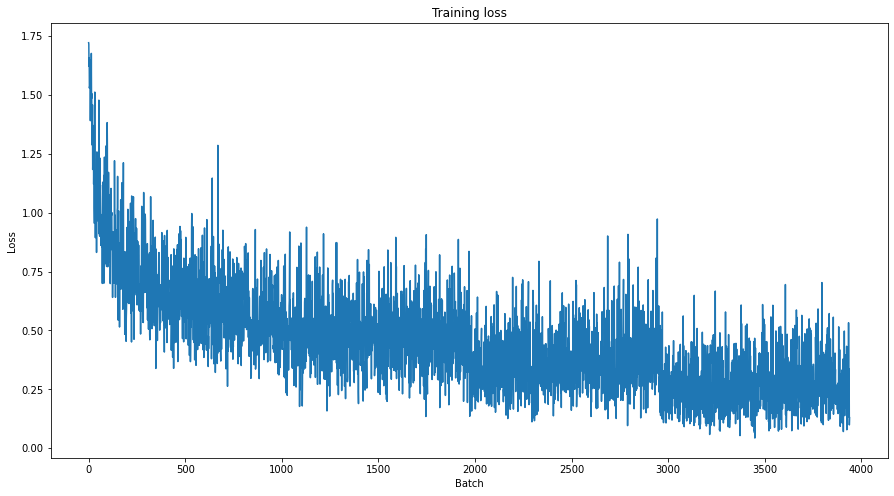

In [27]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

##Predict and Evaluate on Holdout Set

Now we'll load the holdout dataset and prepare inputs just as we did with the training set. 

In [28]:
# Dev set (holdout set with ratings)
# Create sentence and label lists
sentences = data_dev['review'].values

# We need to add special tokens at the beginning and end of each sentence for XLNet to work properly
sentences = [sentence + " [SEP] [CLS]" for sentence in sentences]
labels = data_dev['rating'].values

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

MAX_LEN = 128

# Use the XLNet tokenizer to convert the tokens to their index numbers in the XLNet vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask) 

prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)

batch_size = 32

prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [29]:
# Prediction on dev set

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  # Telling the model not to compute or store gradients, saving memory and speeding up prediction
  with torch.no_grad():
    # Forward pass, calculate logit predictions
    outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

In [32]:
# Flatten the predictions and true values for evaluation on the whole dataset
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
flat_true_labels = [item for sublist in true_labels for item in sublist]


In [34]:
# Add the predicted ratings on dev set to its csv file 
data_dev['predicted_rating'] = flat_predictions
# Convert ratings to its previous state
data_dev['predicted_rating'] = data_dev['predicted_rating'] + 1
data_dev['rating'] = data_dev['rating'] + 1
data_dev.to_csv('SOTA_dev_dataset.csv', encoding='utf-8', index=False)
# data_dev.tail(10)

In [35]:
from sklearn.metrics import classification_report

print('\nClassification report on dev set\n')
print(classification_report(flat_true_labels, flat_predictions, 
                            target_names = ['Rating 1', 'Rating 2', 'Rating 3', 'Rating 4', 'Rating 5']))

# Base
# Accuracy = 0.79 w/ batch 32, Epoch 4, lr= 3e-5
# Accuracy = 0.78 w/ batch 48, Epoch 4, lr= 3e-5
# Accuracy = 0.78 w/ batch 32, Epoch 6, lr= 5e-5
# Accuracy = 0.78 w/ batch 32, Epoch 6, lr= 3e-5
# Accuracy = 0.21 !!! w/ batch 32, Epoch 4, lr= 4e-4 
# Accuracy = 0.78  w/ batch 32, Epoch 4, lr= 1e-5
# Accuracy = 0.78 w/ batch 32, Epoch 4, lr= 3e-5 w/ no emoji removal

# Large 
# Accuracy = 0.75 w/ batch 8, Epoch 4, lr= 3e-5 
# !!! expected higher accuracy! Reason for this accuracy can be a small number of batches due to the GPU limitations
# Going over 8 batchese is computationally very expensive w/ the new Google Colab policy!

# I could not acquire the result out of the large model w/ over 8 batches since \
# it takes 3-hour to finish the first 2 epochs and Colab recently limits the overusage on GPU!

# It seems using over 4 batches on Google Colab GPU will lead to almost the same result as the base model w/ >32 batches. 



Classification report on dev set

              precision    recall  f1-score   support

    Rating 1       0.78      0.90      0.84      1523
    Rating 2       0.81      0.63      0.71      1507
    Rating 3       0.75      0.82      0.78      1483
    Rating 4       0.74      0.80      0.77      1500
    Rating 5       0.88      0.80      0.84      1486

    accuracy                           0.79      7499
   macro avg       0.79      0.79      0.79      7499
weighted avg       0.79      0.79      0.79      7499



In [36]:
# Test set

# Create sentence and label lists
sentences = data_test['review'].values

# We need to add special tokens at the beginning and end of each sentence for XLNet to work properly
sentences = [sentence + " [SEP] [CLS]" for sentence in sentences]

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

MAX_LEN = 128

# Use the XLNet tokenizer to convert the tokens to their index numbers in the XLNet vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask) 

prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)

batch_size = 32

prediction_data = TensorDataset(prediction_inputs, prediction_masks)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [37]:
# Prediction on test set 

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions_test = []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask = batch
  # Telling the model not to compute or store gradients, saving memory and speeding up prediction
  with torch.no_grad():
    # Forward pass, calculate logit predictions
    outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    logits = outputs[0]

  # Move logits to CPU
  logits = logits.detach().cpu().numpy()
  
  # Store predictions and true labels
  predictions_test.append(logits)

In [38]:
# Flatten the predictions and true values for evaluation on the whole dataset
flat_predictions_test = [item for sublist in predictions_test for item in sublist]
flat_predictions_test = np.argmax(flat_predictions_test, axis=1).flatten()

In [39]:
# Add the predicted ratings on test set to its csv file
data_test['predicted_rating'] = flat_predictions_test

# Convert ratings to its previous state
data_test['predicted_rating'] = data_test['predicted_rating'] + 1
data_test.to_csv('SOTA_test_dataset.csv', encoding='utf-8', index=False)
# data_test.tail(10)

In [42]:
# Save the fine-tuned torch model for inference 
#Ref: https://www.kaggle.com/davidashraf/saving-and-loading-models-in-pytorch?scriptVersionId=9041686

torch.save(model.state_dict(), 'xlnet_model_checkpoint')

In [ ]:
# Later to load the model:

# model.load_state_dict(torch.load(filepath))
# model.eval()